## Libraries

In [1]:
import cProfile
import pstats
import numpy as np
import pandas as pd
from timeit import default_timer as timer
from datetime import timedelta
from matplotlib import pyplot as plt

from smooth_output import smooth_fourier
from Jcb import calc_basis_matrix
from R import calc_penalty_matrix
from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from cordex_continuous_v2 import cordex_continuous_v2
from plot_fun import subplot_results
from bayesian_continuous import bo_loop
from Jcb import Jcb
from R import R

# %load_ext autotime

## Settings

In [3]:
runs = 4
levels = np.linspace(-1,1,3).tolist()
epochs = 1_000
optimality = 'A'
method = 'Nelder-Mead'
n_x = [100]
n_b = [2]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])
R_0 = R(*[calc_penalty_matrix(n_b=b) for b in n_b])

## Bayesian Optimization

In [7]:
# start = timer()
# results, best_cr, _ = bo_loop(epochs=100,
#                               runs=runs,
#                               feats=J_cb.shape[0],
#                               optimality=optimality,
#                               initialization_method=None,
#                               J_cb=J_cb,
#                               acq_f='UCB')
# end = timer()
# print(f"Best criterion {np.round(best_cr,3)} for optimality {optimality}. Execution time (s): {timedelta(seconds=end-start)}")

In [8]:
# subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 1000), results=results, J_cb=J_cb)

## Discrete Version

In [9]:
# start = timer()
# results, best_cr, _ = cordex_discrete(runs=runs,
#                                    feats=J_cb.shape[0],
#                                    levels=levels,
#                                    epochs=epochs,
#                                    J_cb=J_cb,
#                                    optimality=optimality)
# end = timer()
# print(f"Optimality: {optimality}"
#       f"\nBest criterion: {np.round(best_cr,3)}"
#       f"\nExecution time (s): {timedelta(seconds=end-start)}")

In [45]:
start = timer()
results, best_cr = cordex_discrete(runs=runs,
                                   f_list=n_x,
                                   scalars=scalars,
                                   levels=levels,
                                   epochs=1000,
                                   J_cb=J_cb,
                                   optimality='A',)
end = timer()
print(f"Optimality: {optimality}"
      f"\nBest criterion: {np.round(best_cr,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

100%|██████████| 1000/1000 [01:43<00:00,  9.63it/s]

Optimality: A
Best criterion: 8.624
Execution time (s): 0:01:43.868950


In [46]:
Z = np.concatenate((np.ones((runs,1)), results[:, :sum(n_x)] @ J_cb, results[:, sum(n_x):]), axis=1)
np.trace(np.linalg.inv(Z.T @ Z))

8.62388360781054

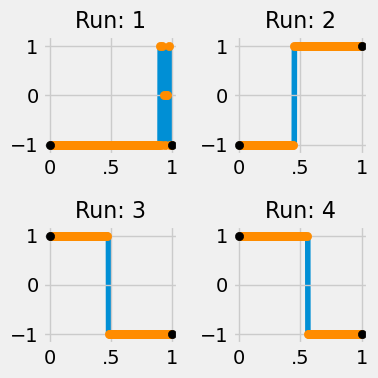

In [47]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 1000), results=results[:, :n_x[0]])

## Continuous Version

In [ ]:
 # Nelder-Mead, L-BFGS-B, Powell, TNC
# with cProfile.Profile() as profile:
#     start = timer()
#     results, best_cr = cordex_continuous(runs=runs,
#                                          f_list=n_x,
#                                          scalars=scalars,
#                                          J_cb=J_cb,
#                                          R_0=None,
#                                          epochs=1000,
#                                          method='L-BFGS-B',
#                                          optimality=optimality,
#                                          random_start=False,
#                                          disable_bar=True,
#                                          penalty=0,
#                                          final_pass=False)
#     end = timer()
#     print(f"Optimality: {optimality}"
#           f"\nBest criterion: {np.round(best_cr,3)}"
#           f"\nExecution time (s): {timedelta(seconds=end-start)}")
#     presults = pstats.Stats(profile).sort_stats(pstats.SortKey.TIME)
#     presults.dump_stats('cordex_continuous.prof')

# Nelder-Mead: 2:10 - 8.455
# L-BFGS-B: 1:44 - 8.44
# Powell: 3:41 - 8.43
# TNC: 2:08 - 8.43
# ~220

In [4]:
start = timer()
results, best_cr = cordex_continuous(runs=runs,
                                     f_list=n_x,
                                     scalars=scalars,
                                     optimality=optimality,
                                     J_cb=J_cb,
                                     R_0=None,
                                     smooth_pen=0,
                                     ridge_pen=0,
                                     epochs=1000,
                                     method='L-BFGS-B',
                                     random_start=False,
                                     disable_bar=True,
                                     final_pass=True,
                                     final_pass_iter=100)
end = timer()
print(f"Optimality: {optimality}"
      f"\nBest criterion: {np.round(best_cr,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

100%|██████████| 1000/1000 [12:17<00:00,  1.36it/s]


Optimality: A
Best criterion: 8.405
Execution time (s): 0:12:51.445637


In [7]:
Z = np.hstack((np.ones((runs,1)), results @ J_cb))
M = Z.T @ Z
np.trace(np.linalg.inv(M))

8.404633780189506

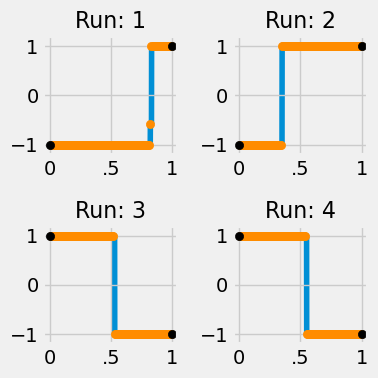

In [8]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 1000), results=results, size=35, save=False)

## Comparissons with Literature

In [ ]:
literature = np.array([
    [2, 2, 4, 8.750],
    [2, 3, 4, 8.828],
    [2, 4, 4, 8.750],
    [2, 8, 4, 8.493],
    [2, 16, 4, 8.427],
    [2, 100, 4, 8.404],
    [2, 2, 8, 3.958],
    [2, 3, 8, 4.287],
    [2, 4, 8, 3.903],
    [2, 8, 8, 3.902],
    [2, 16, 8, 3.887],
    [2, 100, 8, 3.882],
    [2, 2, 12, 2.583],
    [2, 3, 12, 2.778],
    [2, 4, 12, 2.570],
    [2, 8, 12, 2.539],
    [2, 16, 12, 2.520],
    [2, 100, 12, 2.512],
    [3, 3, 4, 386.408],
    [3, 4, 4, 246.869],
    [3, 8, 4, 218.479],
    [3, 16, 4, 208.843],
    [3, 100, 4, 206.884],
    [3, 3, 8, 189.766],
    [3, 4, 8, 103.553],
    [3, 8, 8, 99.109],
    [3, 16, 8, 97.408],
    [3, 100, 8, 96.709],
    [3, 3, 12, 126.409],
    [3, 4, 12, 67.735],
    [3, 8, 12, 65.217],
    [3, 16, 12, 63.610],
    [3, 100, 12, 63.028],

])

In [ ]:
discrete_output_linear = []
for n_b in [2]:
    for run in [4,8,12]:
        for n_x in [2,3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_discrete(runs=run,
                                               feats=J_cb.shape[0],
                                               levels=[-1,0,1],
                                               epochs=1000,
                                               J_cb=J_cb,
                                               optimality='A')
            discrete_output_linear.append(np.round(best_cr,3))

discrete_output_quadratic = []
for n_b in [3]:
    for run in [4,8,12]:
        for n_x in [3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_discrete(runs=run,
                                         feats=J_cb.shape[0],
                                         levels=[-1,0,1],
                                         epochs=1000,
                                         J_cb=J_cb,
                                         optimality='A')
            discrete_output_quadratic.append(np.round(best_cr,3))

In [ ]:
Final = np.round(np.concatenate((literature), axis=1),3)
nm_diff = np.round(np.abs(Final[:,3] - Final[:,4]),3).reshape(-1,1)
bfgs_diff = np.round(np.abs(Final[:,3] - Final[:,5]),3).reshape(-1,1)
p_diff = np.round(np.abs(Final[:,3] - Final[:,6]),3).reshape(-1,1)
tnc_diff = np.round(np.abs(Final[:,3] - Final[:,7]),3).reshape(-1,1)
bo_diff = np.round(np.abs(Final[:,3] - Final[:,8]),3).reshape(-1,1)

Final = np.concatenate((Final, nm_diff, bfgs_diff, p_diff, tnc_diff, bo_diff), axis=1)
Final

In [ ]:
Final_df = pd.DataFrame(Final, columns=['n_b',
                                        'n_x',
                                        'n',
                                        'Michaelidis',
                                        'Nelder-Mead',
                                        'L-BFGS-B',
                                        'Powell',
                                        'TNC',
                                        '|Nelder-Mead diff|',
                                        '|L-BFGS-B diff|',
                                        '|Powell diff|',
                                        '|TNC diff|',
                                        '|BO diff|'])
Final_df.to_csv("Comparisson.csv")